In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import time
import seaborn as sns
import random

import scipy as sp
from scipy.spatial.distance import mahalanobis

# these are user defined modules

### Read the extracted data

In [87]:
data = pd.read_csv('./data/author-career-short-snapshot.csv')

print(data.shape)
credibleAuthors = data[data['career_length'] >= 15]
print(credibleAuthors.shape)

#print(credibleAuthors.head(2))
print(credibleAuthors.columns)

(1708185, 52)
(126157, 52)
Index([u'author', u'start_year', u'career_length', u'gender', u'npub_yr15',
       u'ncit_yr15_pub_yr15', u'ncit_yr15_top_3_pub', u'npub_yr3',
       u'ncit_yr15_pub_yr3', u'ncit_yr14_pub_yr3', u'ncit_yr13_pub_yr3',
       u'ncit_yr12_pub_yr3', u'ncit_yr11_pub_yr3', u'ncit_yr10_pub_yr3',
       u'ncit_yr9_pub_yr3', u'ncit_yr8_pub_yr3', u'ncit_yr7_pub_yr3',
       u'ncit_yr6_pub_yr3', u'ncit_yr5_pub_yr3', u'ncit_yr4_pub_yr3',
       u'ncit_yr3_pub_yr3', u'npub_yr2', u'ncit_yr15_pub_yr2',
       u'ncit_yr14_pub_yr2', u'ncit_yr13_pub_yr2', u'ncit_yr12_pub_yr2',
       u'ncit_yr11_pub_yr2', u'ncit_yr10_pub_yr2', u'ncit_yr9_pub_yr2',
       u'ncit_yr8_pub_yr2', u'ncit_yr7_pub_yr2', u'ncit_yr6_pub_yr2',
       u'ncit_yr5_pub_yr2', u'ncit_yr4_pub_yr2', u'ncit_yr3_pub_yr2',
       u'ncit_yr2_pub_yr2', u'npub_yr1', u'ncit_yr15_pub_yr1',
       u'ncit_yr14_pub_yr1', u'ncit_yr13_pub_yr1', u'ncit_yr12_pub_yr1',
       u'ncit_yr11_pub_yr1', u'ncit_yr10_pub_yr1', u'ncit_yr

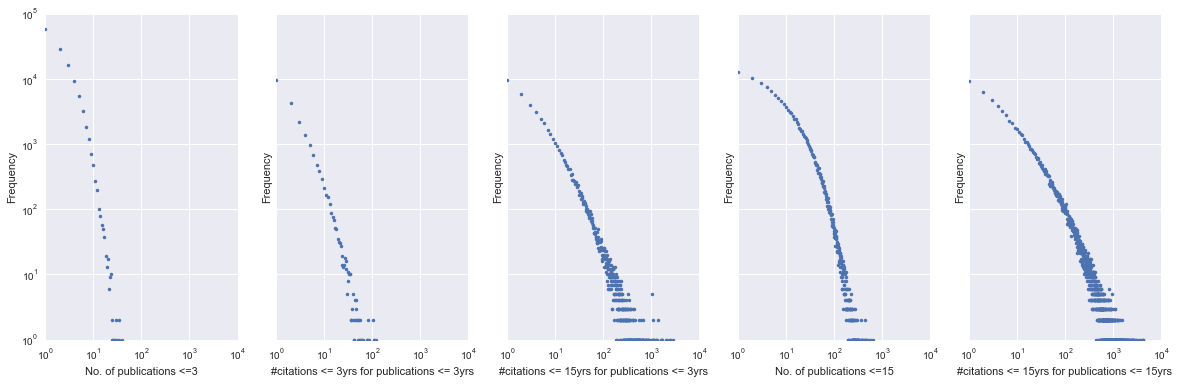

            npub_yr3  ncit_yr3_pub_yr3  ncit_yr15_pub_yr3      npub_yr15  \
count  126157.000000     126157.000000      126157.000000  126157.000000   
mean        2.316962          0.559390           6.701745      16.942318   
std         1.950497          2.338683          35.169849      23.263105   
min         1.000000          0.000000           0.000000       1.000000   
25%         1.000000          0.000000           0.000000       3.000000   
50%         2.000000          0.000000           0.000000       9.000000   
75%         3.000000          0.000000           3.000000      21.000000   
max        40.000000        117.000000        2775.000000     634.000000   

       ncit_yr15_pub_yr15  
count       126157.000000  
mean            31.099511  
std            102.568735  
min              0.000000  
25%              0.000000  
50%              3.000000  
75%             20.000000  
max           4297.000000  


In [88]:
fig, axes = plt.subplots(1,5,figsize=(20,6),sharey=True)
axes[0].plot(credibleAuthors['npub_yr3'].value_counts(),'.')
axes[0].set_xlabel('No. of publications <=3')
axes[0].set_xscale('log')
axes[0].set_xlim(1, 10000)
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')
axes[0].set_ylim(1, 100000)


axes[1].plot(credibleAuthors['ncit_yr3_pub_yr3'].value_counts(),'.')
axes[1].set_xlabel('#citations <= 3yrs for publications <= 3yrs')
axes[1].set_xscale('log')
axes[1].set_xlim(1, 10000)
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')
axes[1].set_ylim(1, 100000)


axes[2].plot(credibleAuthors['ncit_yr15_pub_yr3'].value_counts(),'.')
axes[2].set_xlabel('#citations <= 15yrs for publications <= 3yrs')
axes[2].set_xscale('log')
axes[2].set_xlim(1, 10000)
axes[2].set_ylabel('Frequency')
axes[2].set_yscale('log')
axes[2].set_ylim(1, 100000)


axes[3].plot(credibleAuthors['npub_yr15'].value_counts(),'.')
axes[3].set_xlabel('No. of publications <=15')
axes[3].set_xscale('log')
axes[3].set_xlim(1, 10000)
axes[3].set_ylabel('Frequency')
axes[3].set_yscale('log')
axes[3].set_ylim(1, 100000)


axes[4].plot(credibleAuthors['ncit_yr15_pub_yr15'].value_counts(),'.')
axes[4].set_xlabel('#citations <= 15yrs for publications <= 15yrs')
axes[4].set_xscale('log')
axes[4].set_xlim(1, 10000)
axes[4].set_ylabel('Frequency')
axes[4].set_yscale('log')
axes[4].set_ylim(1, 100000)


plt.show()

print(credibleAuthors[['npub_yr3','ncit_yr3_pub_yr3','ncit_yr15_pub_yr3','npub_yr15','ncit_yr15_pub_yr15']].describe())
# print(credibleAuthors['ncit_yr3_pub_yr3'].describe())
# print(credibleAuthors['ncit_yr15_pub_yr3'].describe())
# print(credibleAuthors['npub_yr15'].describe())
# print(credibleAuthors['ncit_yr15_pub_yr15'].describe())

### Remove authors who have not been citated at all

In [89]:
print('No. of authors - ',credibleAuthors.shape)
print('No. authors who have not been cited at all  - ',credibleAuthors[credibleAuthors['ncit_yr15_pub_yr15'] == 0].shape)
credibleAuthors = credibleAuthors[credibleAuthors['ncit_yr15_pub_yr15'] != 0]
print('No. of authors after removal - ',credibleAuthors.shape)

('No. of authors - ', (126157, 52))
('No. authors who have not been cited at all  - ', (45956, 52))
('No. of authors after removal - ', (80201, 52))


#### No. of publications <= 3 years has a power law effect. Since a lot of authors published very few papers and very few have published a lot, binning is done with non-linear ranges.
* Authors who have published more than 15 papers are in one bin (all the way upto 40)
* 10 to 14 in one bin
* 7 to 9, 4 to 6, 3, 2 ,1 are binned respectively

(1, 100000)

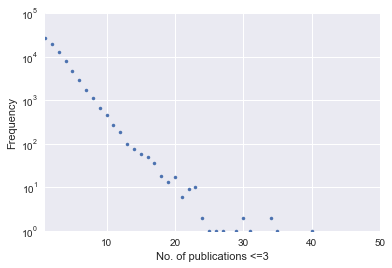

In [90]:
fig, ax =  plt.subplots(1,1)
ax.plot(credibleAuthors['npub_yr3'].value_counts(),'.')
ax.set_xlabel('No. of publications <=3')
#ax.set_xscale('log')
ax.set_xlim(1, 50)
ax.set_ylabel('Frequency')
ax.set_yscale('log')
ax.set_ylim(1, 100000)

In [91]:
year_bins = [1,2,3,4,7,10,16,100]
#bins - contains the year groups and labels contains all the group except the last one
credibleAuthors['npub_yr3_bin'] = pd.cut(credibleAuthors['npub_yr3'], bins=year_bins, labels=year_bins[:-1],\
                                       include_lowest=True, right=False)

credibleAuthors['npub_yr3_bin'].value_counts()

1     27251
2     19324
4     15865
3     12896
7      3553
10     1140
16      172
dtype: int64

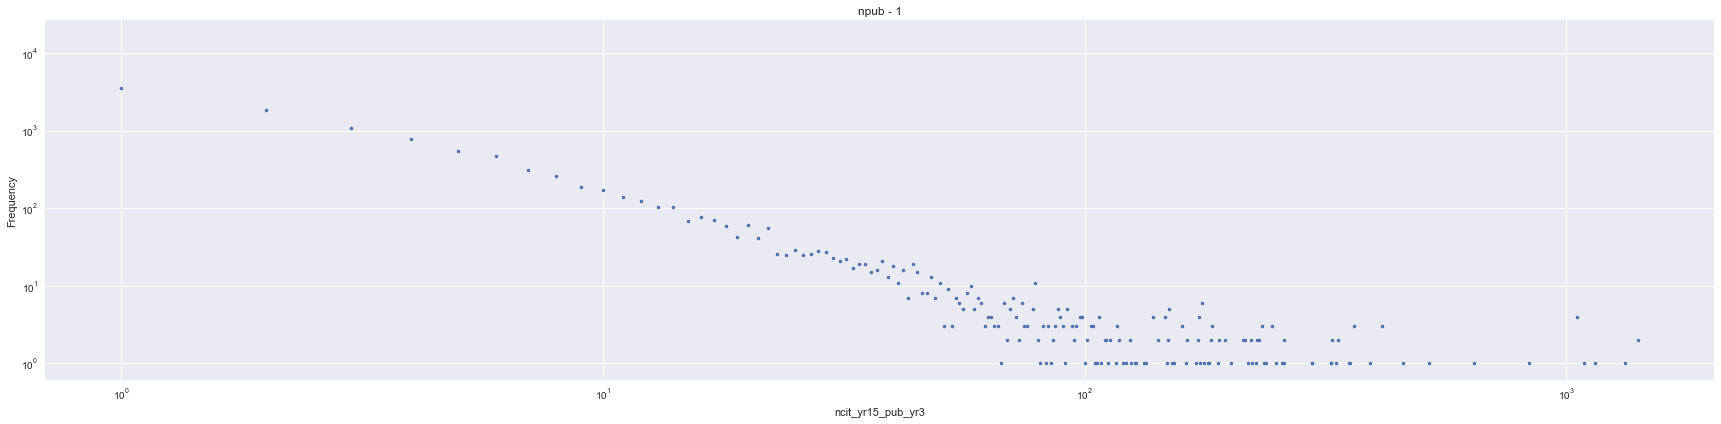

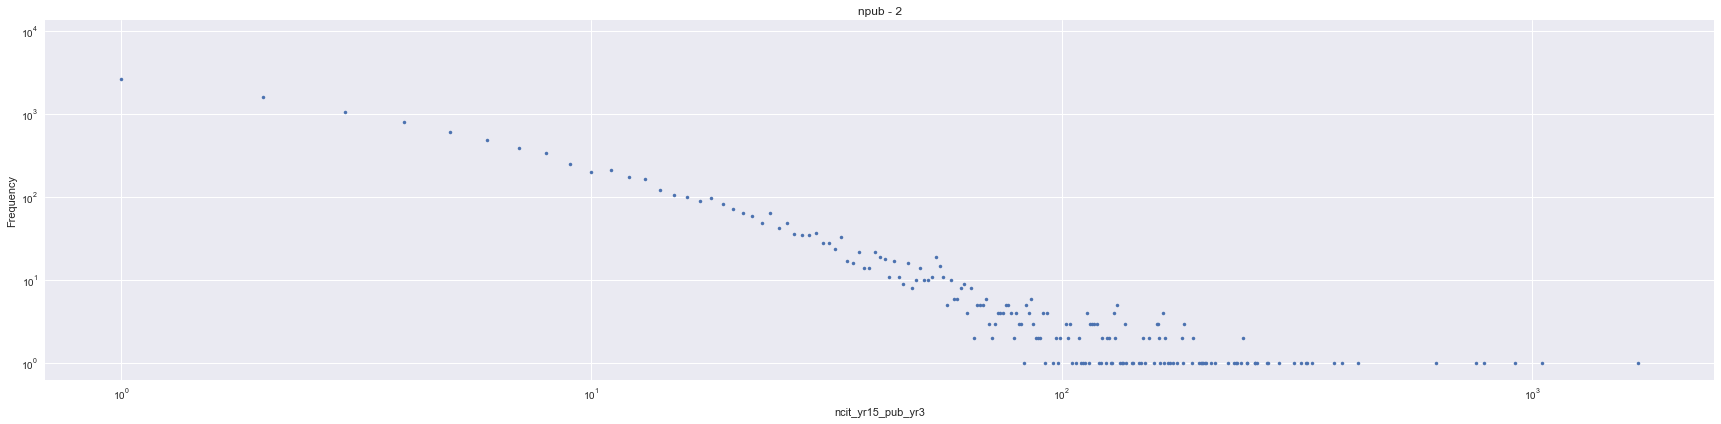

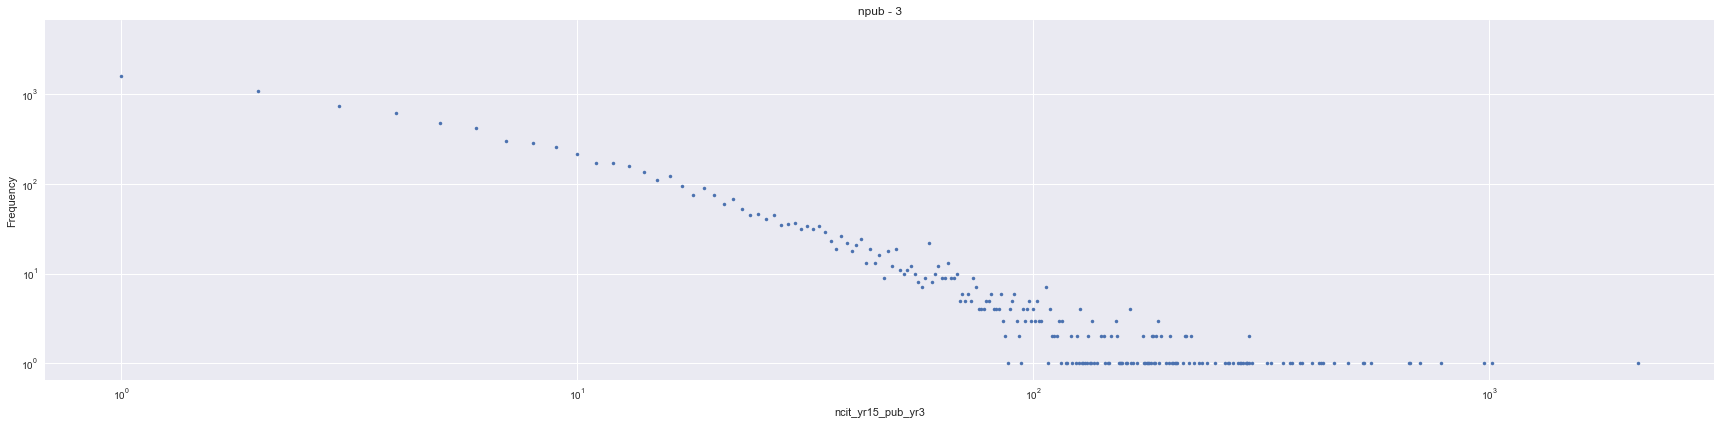

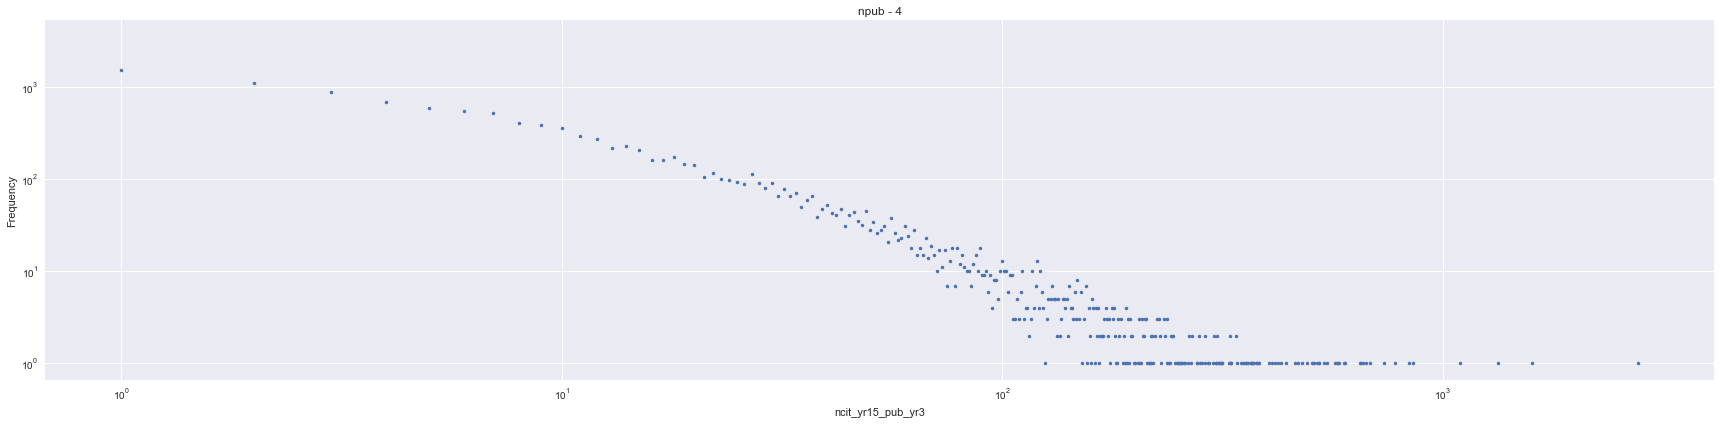

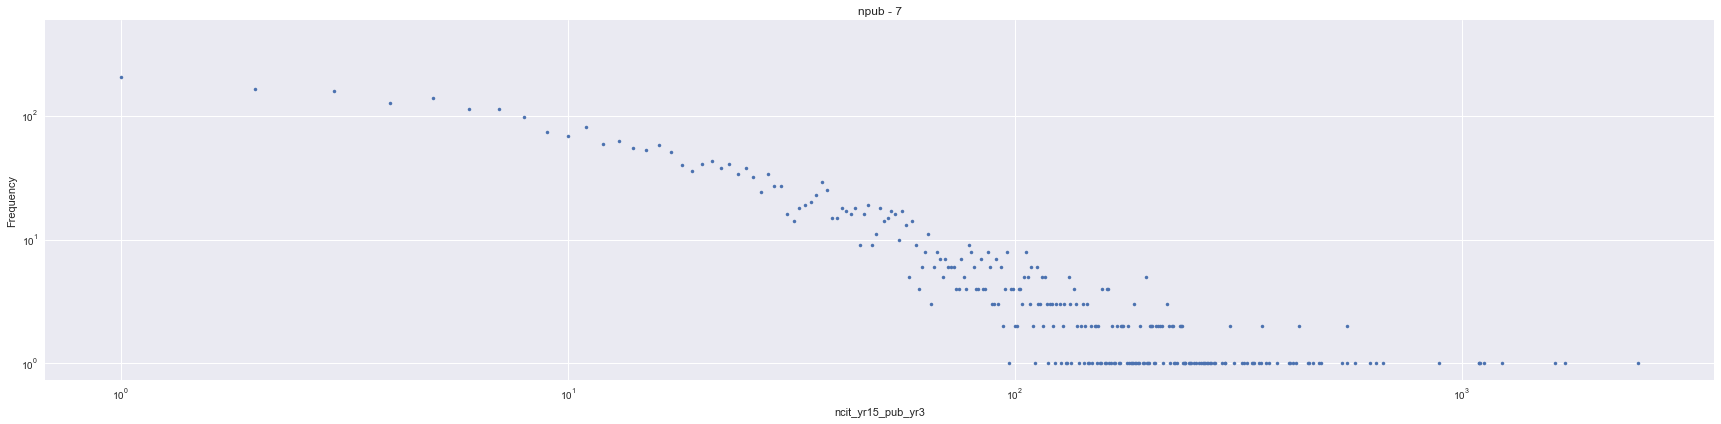

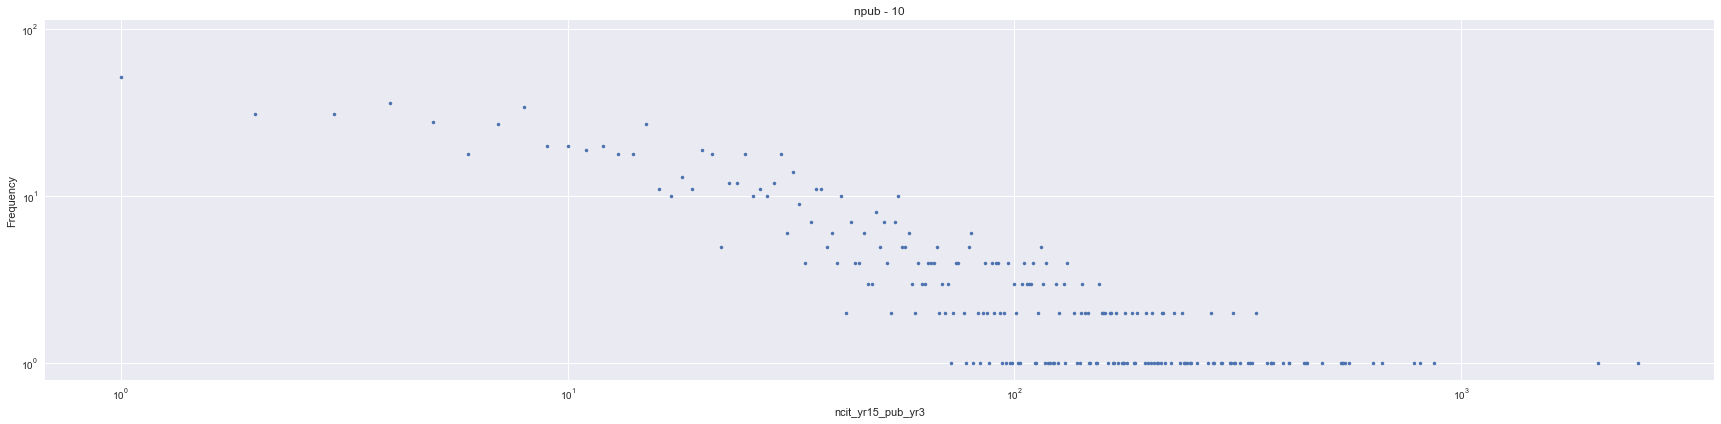

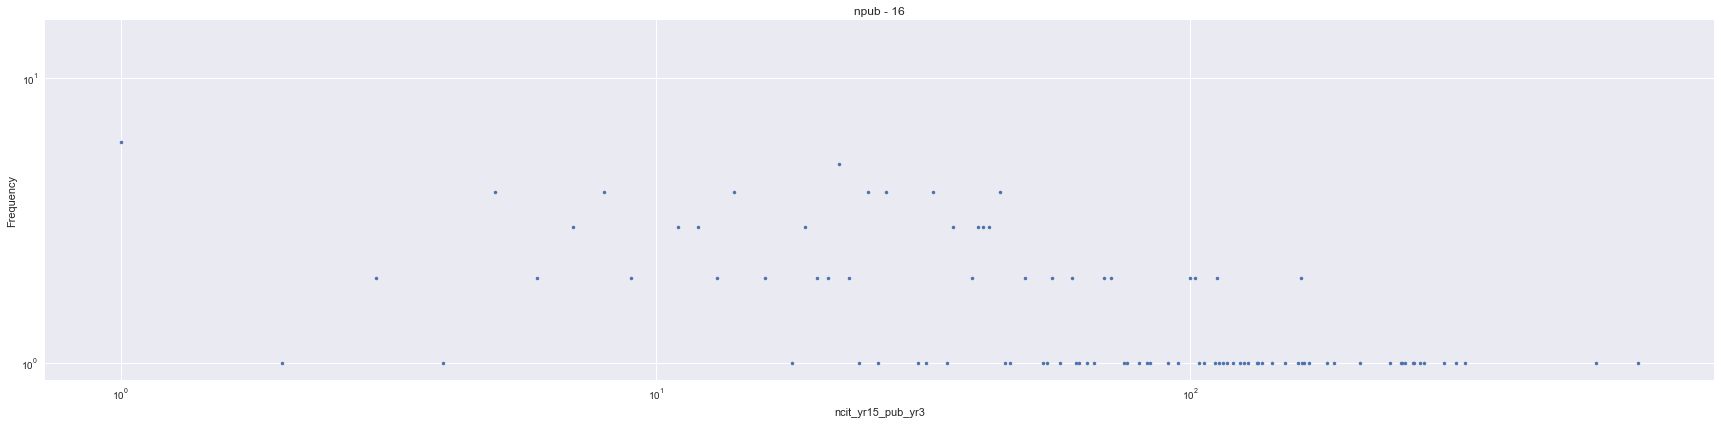

In [93]:

i = 0
#j = 0
bins = credibleAuthors['npub_yr3_bin'].unique().to_dense()
bins = np.sort(bins)

nrows = 1
ncols = 1
    
for b in bins:
    fig, axes = plt.subplots(nrows, ncols, figsize=(24, 6), sharey=True)
    tmpData = credibleAuthors[credibleAuthors['npub_yr3_bin'] == b]
    axes.set_title('npub - '+str(b))
    axes.plot(tmpData['ncit_yr15_pub_yr3'].value_counts(),'.')
    axes.set_xlabel('ncit_yr15_pub_yr3')
    axes.set_xscale('log')

    axes.set_ylabel('Frequency')
    axes.set_yscale('log')
#    axes.set_ylim(1, 100000)
    
    i = i+1
    plt.tight_layout()
    
    #print(tmpData['ncit_yr15_pub_yr3'].describe())

plt.show()

#print(credibleAuthors[['npub_yr3','ncit_yr3_pub_yr3','ncit_yr15_pub_yr3','npub_yr15','ncit_yr15_pub_yr15']].describe())

In [ ]:
min_year = data['year'].min() 

# the final year was getting missed out from grouping. Inorder to avoid that the max year is extended by one group year
# pd.cut() function groups the years and allows the user to assign labels to each group. 
# It is designed in such a way that it was by default leaving the label for the last group. In order to fix this issue, 
# an extra bin is added to the last, so that, the second last (which is the actual last with respect to this context) is preserved

# this max_year is used only for grouping - so no worries :-)
max_year = data['year'].max() + 2*group_year 
yearGroups = range(min_year, max_year, group_year)

#bins - contains the year groups and labels contains all the group except the last one
data['year'] = pd.cut(data['year'], bins=yearGroups, labels=yearGroups[:-1],\
                                       include_lowest=True, right=False)
if 'start_year' in data.columns:
    data['start_year'] = pd.cut(data['start_year'],bins=yearGroups, labels=yearGroups[:-1],\
                                include_lowest=True, right=False)

if 'end_year' in data.columns:
    data['end_year'] = pd.cut(data['end_year'],bins=yearGroups, labels=yearGroups[:-1],\
                              include_lowest=True, right=False)

# within the group - all the multiple efforts need to be joined together
data[criterion] = data.groupby(['year', 'author'])[criterion].transform(np.sum)

In [5]:
data['npub_yr3'].value_counts()

1     1084286
2      311071
3      137259
4       71404
5       40043
6       23447
7       14284
8        8811
9        5750
10       3780
11       2330
12       1630
13       1120
14        749
15        559
16        398
17        302
18        214
19        161
20        125
21        111
22         72
23         48
24         47
25         41
29         18
26         18
27         16
28         13
30         13
31         11
34         10
36          7
32          6
35          6
33          5
38          3
50          3
45          2
47          2
58          1
49          1
48          1
68          1
37          1
44          1
41          1
40          1
39          1
69          1
Name: npub_yr3, dtype: int64

In [6]:
data['ncit_yr3_pub_yr3'].value_counts()

0         1481942
1          104297
2           45461
3           23074
4           14394
5            9073
6            6401
7            4555
8            3488
9            2595
10           2070
11           1643
12           1343
13           1066
14            881
15            744
16            663
17            515
18            427
19            335
20            326
22            283
21            261
24            237
23            212
26            196
25            160
28            122
27            109
29             95
           ...   
87              2
85              2
83              2
77              2
115             2
70              2
66              2
132             1
732055          1
184             1
135             1
147             1
164             1
236             1
1134            1
123             1
98              1
117             1
116             1
114             1
107             1
106             1
105             1
97              1
93        

In [7]:
data['ncit_yr15_pub_yr3'].value_counts()

0         1328874
1          108352
2           59204
3           37043
4           26136
5           19248
6           15418
7           11979
8            9775
9            8153
10           7177
11           6067
12           5404
13           4522
14           4179
15           3456
16           3326
17           2745
18           2565
19           2431
20           2285
22           1954
21           1907
23           1705
24           1581
25           1468
26           1428
27           1245
28           1178
29           1102
           ...   
575             1
578             1
579             1
580             1
581             1
583             1
596             1
548             1
546             1
541             1
506             1
478             1
487             1
488             1
489             1
492             1
493             1
500             1
504             1
507             1
537             1
508             1
510             1
517             1
518       

In [4]:
# credibleAuthors["ncit_yr15_pub_yr15_log"]=credibleAuthors['ncit_yr15_pub_yr15'].apply(lambda x: np.log(1 + x))
# credibleAuthors["ncit_yr15_pub_yr15_log"].value_counts().plot()

# from scipy.stats import norm
# sns.distplot(credibleAuthors['norm_ncit_yr15_pub_yr3'], fit=norm, kde=False)
# plt.show()
# plt.hist(np.log(1+credibleAuthors['ncit_yr15_pub_yr15']),bins=100)
# plt.xlim(-0.10,6)

# credibleAuthors[credibleAuthors['ncit_yr3_pub_yr3'] > 22]['ncit_yr3_pub_yr3'].value_counts().plot()
# credibleAuthors[credibleAuthors['ncit_yr3_pub_yr3'] > 22]['ncit_yr3_pub_yr3'].describe()

#### Segregate the authors into producers/Achievers - low/high bin and cross check broadly whether they are correct with the other sources in the web

In [5]:
credibleAuthors.sort_values(by='npub_yr3', ascending=False)[['author','start_year','npub_yr3','npub_yr15',
                                                             'ncit_yr3_pub_yr3',
                                                             'ncit_yr15_pub_yr3']].head(10)

,author,start_year,npub_yr3,npub_yr15,ncit_yr3_pub_yr3,ncit_yr15_pub_yr3
617969,irith pomeranz,1991,40,306,24,261
1285949,rohit goyal,1997,35,44,23,111
1408279,sonia fahmy,1997,34,101,23,113
934751,mahmut t. kandemir,1997,34,457,24,248
232764,charles safran,1997,31,61,0,0
1021438,michael backes 1,2002,30,153,30,326
1137696,omer f. rana,1999,30,214,9,45
57266,alexander maedche,2000,29,74,43,573
832347,klaus jansen,1992,27,111,0,27
48197,albrecht schmidt 1,1999,26,234,15,186


In [6]:
#anyone who published less than 5 papers in 3 yrs is a low producer.
#if their work got only 2 to 5 citations then they are low achievers too
#if their work got between 50 and 100 citations then are considered as high achiever
lowProducers = credibleAuthors[credibleAuthors['npub_yr3'] <= 5]
low2Achievers = lowProducers[(lowProducers['ncit_yr3_pub_yr3'] >=2) & (lowProducers['ncit_yr3_pub_yr3'] <=5)]
print(low2Achievers[['author','start_year','npub_yr3','npub_yr15','ncit_yr3_pub_yr3',
                                                             'ncit_yr15_pub_yr3']].head(10))

lowProductionhighAchievers = lowProducers[(lowProducers['ncit_yr3_pub_yr3'] >=50) & (lowProducers['ncit_yr3_pub_yr3'] <=100)]
print(lowProductionhighAchievers[['author','start_year','npub_yr3','npub_yr15','ncit_yr3_pub_yr3',
                                                             'ncit_yr15_pub_yr3']].head(10))

                  author  start_year  npub_yr3  npub_yr15  ncit_yr3_pub_yr3  \
298           a. a. khan        1994         2          5                 5   
1884       a. bensoussan        1972         1          1                 5   
4533          a. fantini        1997         1          1                 2   
4768   a. frank ackerman        1989         3          3                 5   
5230              a. gay        1993         1          1                 2   
5367      a. gill waters        1984         2          4                 4   
8614              a. lee        1983         1          2                 5   
10750  a. nico habermann        1971         4         11                 5   
12438       a. ravindran        1980         2          5                 2   
12781   a. s. a. du toit        2001         2          9                 2   

       ncit_yr15_pub_yr3  
298                   32  
1884                  14  
4533                   2  
4768                  

In [7]:
#anyone who published atleast 12 papers in 3 yrs is a high producer.
#if their work got only 2 to 5 citations then they are low achievers
#if their work got between 50 and 100 citations then are considered as high achievers
highProducers = credibleAuthors[credibleAuthors['npub_yr3'] >= 12]
highProductionLowAchievers = highProducers[(highProducers['ncit_yr3_pub_yr3'] >=2) & (highProducers['ncit_yr3_pub_yr3'] <=5)]
print(highProductionLowAchievers[['author','start_year','npub_yr3','npub_yr15','ncit_yr3_pub_yr3',
                                                             'ncit_yr15_pub_yr3']].head(10))
high2Achievers = highProducers[(highProducers['ncit_yr3_pub_yr3'] >=50) & (highProducers['ncit_yr3_pub_yr3'] <=100)]
print(high2Achievers.sort_values(by='ncit_yr3_pub_yr3', ascending=False)[['author','start_year','npub_yr3','npub_yr15','ncit_yr3_pub_yr3',
                                                                          'ncit_yr15_pub_yr3']].head(10))

                         author  start_year  npub_yr3  npub_yr15  \
10520         a. n. rajagopalan        1997        12         50   
16478            aapo hyvärinen        1996        12         90   
18084               abbes amira        2001        20        111   
47244      alberto garcía ortiz        2002        17         50   
61229  alexandros eleftheriadis        1993        13         61   
77259     amit k. roy-chowdhury        2001        15        144   
84484             anders heyden        1995        12         93   
86574     andrea e. f. clementi        1994        16         56   
91026     andreas schmietendorf        2000        17         41   
93193           andrew b. kahng        1990        16        187   

       ncit_yr3_pub_yr3  ncit_yr15_pub_yr3  
10520                 4                 37  
16478                 3                337  
18084                 2                  3  
47244                 5                  5  
61229                 3   

In [8]:
#credibleAuthors[credibleAuthors['norm_ncit_yr15_pub_yr3']==0]
# credibleAuthors['norm_ncit_yr15_pub_yr3'].dtype
# credibleAuthors['norm_ncit_yr15_pub_yr3'].hist(bins=10000)
# 1/credibleAuthors['ncit_yr15_pub_yr3'].max()

('Actual range values', 4297.0, 0.0)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


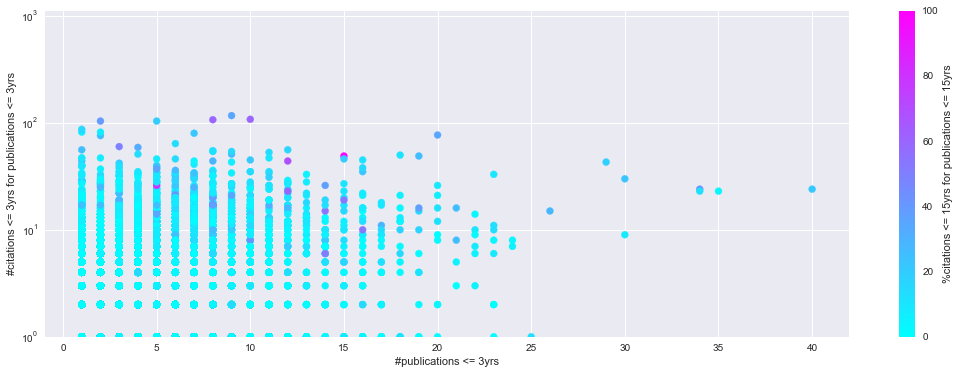

In [9]:
# Normalize(0 to 100) the citation obtained within 15 years for publication within 15 yrs
credibleAuthors['norm_ncit_yr15_pub_yr15'] = 100 * ((credibleAuthors['ncit_yr15_pub_yr15'] - credibleAuthors['ncit_yr15_pub_yr15'].min()) /
                                            (credibleAuthors['ncit_yr15_pub_yr15'].max() - credibleAuthors['ncit_yr15_pub_yr15'].min()))

print('Actual range values',credibleAuthors['ncit_yr15_pub_yr15'].max(), credibleAuthors['ncit_yr15_pub_yr15'].min())


fig, axes = plt.subplots(figsize=(18,6))

handle = axes.scatter(credibleAuthors['npub_yr3'], credibleAuthors['ncit_yr3_pub_yr3'], 
                       c=credibleAuthors['norm_ncit_yr15_pub_yr15'], cmap='cool')
axes.set_xlabel('#publications <= 3yrs')
axes.set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes.set_yscale('log')
axes.set_ylim(ymin=1)
cbar = fig.colorbar(handle)
cbar.set_label('%citations <= 15yrs for publications <= 15yrs')

plt.show()
#fig.savefig('fig/cit3_15yr-for-pub3_15yr.png')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('Log values', 8.3659050772024557, 0.0)


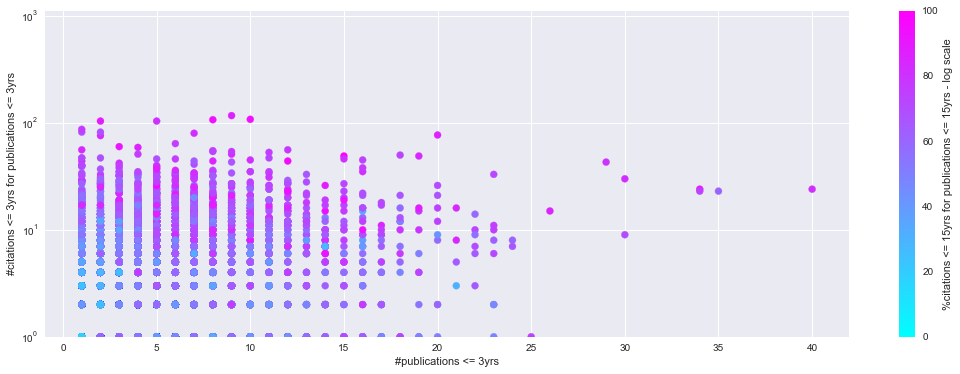

In [10]:
credibleAuthors["ncit_yr15_pub_yr15_log"]=credibleAuthors['ncit_yr15_pub_yr15'].apply(lambda x: np.log(1 + x))
temp_max=credibleAuthors['ncit_yr15_pub_yr15_log'].max()
temp_min=credibleAuthors['ncit_yr15_pub_yr15_log'].min()
print('Log values',temp_max, temp_min)
credibleAuthors['norm_ncit_yr15_pub_yr15_log'] = credibleAuthors.ncit_yr15_pub_yr15_log.apply(lambda x: 100 * (float(x - temp_min)
                                                                                                               /float(temp_max - temp_min)))

fig, axes = plt.subplots(figsize=(18,6))

handle = axes.scatter(credibleAuthors['npub_yr3'], credibleAuthors['ncit_yr3_pub_yr3'], 
                   c=credibleAuthors['norm_ncit_yr15_pub_yr15_log'], cmap='cool')
axes.set_xlabel('#publications <= 3yrs')
axes.set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes.set_yscale('log')
axes.set_ylim(ymin=1)
cbar = fig.colorbar(handle)
cbar.set_label('%citations <= 15yrs for publications <= 15yrs - log scale')

plt.show()

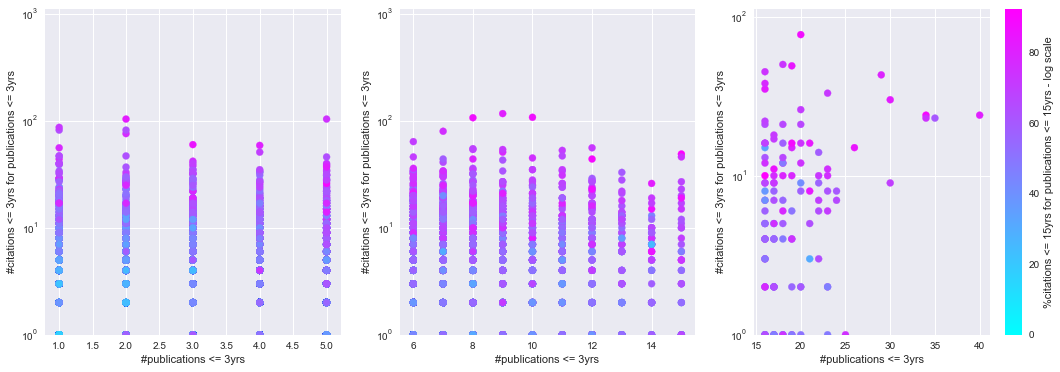

In [11]:
lowProducers = credibleAuthors[credibleAuthors['npub_yr3'] <= 5]
normalProducers = credibleAuthors[credibleAuthors['npub_yr3'] > 5]
normalProducers =  normalProducers[normalProducers['npub_yr3'] <= 15]
extraOrdinaryProducers = credibleAuthors[credibleAuthors['npub_yr3'] > 15]

fig, axes = plt.subplots(1,3,figsize=(18,6))
handle = axes[0].scatter(lowProducers['npub_yr3'], lowProducers['ncit_yr3_pub_yr3'], 
                   c=lowProducers['norm_ncit_yr15_pub_yr15_log'], cmap='cool')
axes[0].set_xlabel('#publications <= 3yrs')
axes[0].set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes[0].set_yscale('log')
axes[0].set_ylim(ymin=1)

handle = axes[1].scatter(normalProducers['npub_yr3'], normalProducers['ncit_yr3_pub_yr3'], 
                   c=normalProducers['norm_ncit_yr15_pub_yr15_log'], cmap='cool')
axes[1].set_xlabel('#publications <= 3yrs')
axes[1].set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes[1].set_yscale('log')
axes[1].set_ylim(ymin=1)

handle = axes[2].scatter(extraOrdinaryProducers['npub_yr3'], extraOrdinaryProducers['ncit_yr3_pub_yr3'], 
                   c=extraOrdinaryProducers['norm_ncit_yr15_pub_yr15_log'], cmap='cool')
axes[2].set_xlabel('#publications <= 3yrs')
axes[2].set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes[2].set_yscale('log')
axes[2].set_ylim(ymin=1)


cbar = fig.colorbar(handle)
cbar.set_label('%citations <= 15yrs for publications <= 15yrs - log scale')

plt.show()

In [12]:
print(credibleAuthors['ncit_yr3_pub_yr3'].describe())
print(credibleAuthors['ncit_yr3_pub_yr3'].value_counts().cumsum().head(10))

count    126157.000000
mean          0.559390
std           2.338683
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         117.000000
Name: ncit_yr3_pub_yr3, dtype: float64
0    104816
1    114231
2    118471
3    120653
4    122042
5    123019
6    123686
7    124162
8    124542
9    124833
Name: ncit_yr3_pub_yr3, dtype: int64


In [13]:
controlGroup =  credibleAuthors[credibleAuthors['ncit_yr3_pub_yr3'] < 10]
treatmentGroup =  credibleAuthors[credibleAuthors['ncit_yr3_pub_yr3'] >= 10]
filteredControlGroup = controlGroup.head(treatmentGroup.shape[0]*10)

In [14]:
print(controlGroup.shape)
print(treatmentGroup.shape)
print(filteredControlGroup.shape)

(124833, 25)
(1324, 25)
(13240, 25)


In [15]:
print(treatmentGroup.columns)
print(controlGroup.columns)

Index([u'author', u'start_year', u'career_length', u'gender', u'npub_yr15',
       u'ncit_yr15_pub_yr15', u'ncit_yr15_top_3_pub', u'npub_yr3',
       u'ncit_yr15_pub_yr3', u'ncit_yr5_pub_yr3', u'ncit_yr4_pub_yr3',
       u'ncit_yr3_pub_yr3', u'npub_yr2', u'ncit_yr15_pub_yr2',
       u'ncit_yr4_pub_yr2', u'ncit_yr3_pub_yr2', u'ncit_yr2_pub_yr2',
       u'npub_yr1', u'ncit_yr15_pub_yr1', u'ncit_yr3_pub_yr1',
       u'ncit_yr2_pub_yr1', u'ncit_yr1_pub_yr1', u'norm_ncit_yr15_pub_yr15',
       u'ncit_yr15_pub_yr15_log', u'norm_ncit_yr15_pub_yr15_log'],
      dtype='object')
Index([u'author', u'start_year', u'career_length', u'gender', u'npub_yr15',
       u'ncit_yr15_pub_yr15', u'ncit_yr15_top_3_pub', u'npub_yr3',
       u'ncit_yr15_pub_yr3', u'ncit_yr5_pub_yr3', u'ncit_yr4_pub_yr3',
       u'ncit_yr3_pub_yr3', u'npub_yr2', u'ncit_yr15_pub_yr2',
       u'ncit_yr4_pub_yr2', u'ncit_yr3_pub_yr2', u'ncit_yr2_pub_yr2',
       u'npub_yr1', u'ncit_yr15_pub_yr1', u'ncit_yr3_pub_yr1',
       u'ncit_

In [16]:
#controlGroup['npub_yr3']

In [17]:
tmp = controlGroup.shape[0]
tmp

124833

In [18]:
covariance = credibleAuthors[['npub_yr3']].cov()
invCovariance = sp.linalg.inv(covariance)
print(invCovariance)

[[ 0.26285094]]


In [19]:
tmpGroup = (controlGroup['npub_yr3'].subtract(2))
print(tmpGroup.shape)
tmpGroup = tmpGroup.reshape(tmp,1)
print(tmpGroup.shape)

(124833,)
(124833, 1)


In [20]:
tmpGroup1 = np.dot(tmpGroup, invCovariance) 
print(tmpGroup1.shape)

(124833, 1)


In [21]:
tmpGroup1.shape

(124833, 1)

In [22]:
tmpGroup.shape

(124833, 1)

In [23]:
tmpGroup.T.shape

(1, 124833)

In [24]:
np.multiply(tmpGroup1, tmpGroup)

array([[ 0.26285094],
       [ 0.26285094],
       [ 0.26285094],
       ..., 
       [ 0.        ],
       [ 0.26285094],
       [ 0.        ]])

In [25]:
tmp

124833

In [26]:
def anotherFunc(var, counter):
    print(var)
    counter.append(1)
    return 0

counter = []
treatmentGroup.apply(lambda x:(anotherFunc(x['npub_yr3'], counter)), axis=1)
print(sum(counter))
print(treatmentGroup.shape)

5
5
7
1
10
3
4
8
1
3
2
7
11
15
10
12
6
2
2
4
7
1
3
2
15
6
26
2
4
5
23
1
5
5
5
7
1
29
3
18
6
7
5
6
8
13
4
3
6
9
4
8
7
4
8
15
1
5
7
7
6
10
4
16
2
7
8
7
10
6
4
8
6
1
10
10
12
6
10
10
7
5
3
6
4
4
10
12
4
5
10
10
1
6
4
13
3
7
9
10
3
3
4
6
4
14
10
3
6
3
5
3
7
8
13
3
6
6
4
6
2
6
4
2
6
4
3
3
6
1
22
5
19
4
4
5
3
10
1
2
5
3
3
7
1
1
6
3
6
6
4
7
1
7
1
2
8
1
11
2
4
5
12
1
9
3
5
3
4
12
15
6
2
1
10
1
9
4
8
6
1
3
3
9
5
7
8
1
6
2
7
2
5
9
6
10
8
5
6
8
6
6
13
8
8
5
6
1
5
3
9
5
9
12
6
8
7
3
10
7
13
8
3
22
4
2
2
6
4
13
3
5
23
9
6
5
3
7
4
3
4
8
5
6
1
3
3
2
3
7
7
1
11
4
9
2
5
5
1
1
11
4
1
3
7
3
6
8
2
14
9
2
4
4
8
3
7
2
4
6
8
11
2
6
6
15
12
6
8
12
9
3
1
3
9
12
7
8
1
3
3
10
1
3
6
1
1
15
8
8
1
2
9
3
6
1
8
16
1
5
9
13
2
5
9
18
8
6
3
4
3
2
8
2
1
4
4
4
3
4
3
17
4
4
8
2
5
4
5
1
3
10
3
7
2
5
1
12
10
17
12
2
4
8
4
10
11
1
8
1
3
5
7
11
1
2
6
2
7
9
5
16
1
12
16
3
9
5
15
7
5
6
7
9
5
1
7
7
7
8
7
6
5
8
20
2
14
5
11
3
8
6
3
4
3
10
1
7
1
6
2
5
7
8
5
2
6
7
5
8
6
3
11
2
2
1
5
3
6
4
12
11
1
10
4
4
9
3
3
14
1
6
3
7
4
3
8
13
5
6

In [69]:
def mahanabFunc(treatmentVar, controlGroup, invCovariance,counterVar):
    print(type(controlGroup))

    print('Is',type(treatmentVar))
    counterVar.append(1)
    print(sum(counterVar))
    tmpShape = controlGroup.shape
    tmpRows = controlGroup.shape[0]
    #print('1 - is fine')
    if (len(tmpShape) > 1):
        tmpColumns = controlGroup.shape[1]
    else:
        tmpColumns = 1
    if (treatmentVar is None):
        return np.NaN
    #print('2 - is fine')
    tmpGroup = (controlGroup.subtract(treatmentVar))
    print('X',type(tmpGroup))
    #print(tmpGroup.shape)
    #tmpGroup = pd.Series.reshape(tmpGroup, tmpRows, tmpColumns)
    print('After Reshape',type(tmpGroup))
    #print(tmpGroup.shape)
    #print('3 - is fine')
    tmpGroup1 = pd.Series.dot(tmpGroup.T, invCovariance) 
    print('After dot',type(tmpGroup1))

    if (tmpColumns == 1):
        tmpResult = pd.Series.multiply(tmpGroup1, tmpGroup)
    else:
        tmpResult = pd.Series.dot(tmpGroup1, tmpGroup.T)
    print('4 - is fine')
    #print('Result:', np.sqrt(tmpResult))  
    print(type(tmpResult))
    tmpResult =  pd.Series.sqrt(tmpResult)
    print(type(tmpResult))
    print(tmpResult.shape)
    return tmpResult
    #print(type(tmpGroup))
#     if(sum(counterVar) > 100 ):
#         return np.array([0,1,23,2343,5,656])
#     else:
#         return np.array([0,1])
    #return np.array([0,1,23,2343,5,656])

In [70]:
output_variable = 'ncit_yr15_pub_yr15'

controlGroup.loc[0][output_variable]

9.0

In [71]:
controlGroup['npub_yr3'].shape

(124833,)

In [72]:
# for index, row in treatmentGroup.iterrows():
#     print (np.sqrt(np.dot(np.dot((controlGroup['npub_yr3']-row[['npub_yr3']]),invCovariance),(controlGroup['npub_yr3']-row[['npub_yr3']]).T)))
#     break

#treatmentGroup.apply(lambda x:(x[['npub_yr3']] - controlGroup[['npub_yr3']]), axis=1)
# treatmentGroup.apply(lambda x:( np.sqrt( np.dot(controlGroup['npub_yr3'].subtract(x['npub_yr3']), 
#                                         (controlGroup['npub_yr3'].subtract(x['npub_yr3'])).T))), axis=1)

# treatmentGroup.apply(lambda x:(np.sqrt(
#             np.multiply(np.dot(((controlGroup['npub_yr3'].subtract(x['npub_yr3'])).reshape(tmp,1)), invCovariance),
#                        ((controlGroup['npub_yr3'].subtract(x['npub_yr3'])).reshape(tmp,1))))), axis=1)

# treatmentGroup.apply(lambda x:(np.sqrt(
#             np.multiply(np.dot(((controlGroup['npub_yr3'].subtract(x['npub_yr3'])).reshape(tmp,1)), invCovariance),
#                        ((controlGroup['npub_yr3'].subtract(x['npub_yr3'])).reshape(tmp,1))))), axis=1)
counter = []
# treatmentGroup.apply(lambda x:(mahanabFunc( x['npub_yr3'], controlGroup['npub_yr3'], invCovariance, counter)), axis=1)

newData = pd.DataFrame(columns=['control_index','control_output', 'treatment_index','treatment_output'])

output_variable = 'ncit_yr15_pub_yr15'

for index, row in treatmentGroup.iterrows():
    temp = mahanabFunc( row['npub_yr3'], controlGroup['npub_yr3'], invCovariance, counter)
    newData.append({'control_index':temp.idxmin(), 'control_output':controlGroup[temp.idxmin()][output_variable], 
                    'treatment_index':index, 'treatment_output':row[output_variable]}, ignore_index=True)
    #print(index, temp.idxmin())


<class 'pandas.core.series.Series'>
('Is', <type 'int'>)
1
('X', <class 'pandas.core.series.Series'>)
('After Reshape', <class 'pandas.core.series.Series'>)


Exception: Dot product shape mismatch, (124833,) vs (1, 1)

In [74]:
sum(counter)

1325

In [62]:
treatmentGroup.shape

(1324, 22)

In [63]:
controlGroup.shape

(124833, 22)

In [35]:
#tempCov = credibleAuthors[['npub_yr3', 'ncit_yr3_pub_yr3']].cov()
#invCov = sp.linalg.inv(tempCov)

vecMahalanobis = np.vectorize(mahalanobis)

covariance = credibleAuthors[['npub_yr3']].cov()
invCovariance = sp.linalg.inv(covariance)
i = 0
for index, row in treatmentGroup.iterrows():
    #print(row['npub_yr3'])
    temp = filteredControlGroup.apply(lambda x: (mahalanobis(row[['npub_yr3']], x['npub_yr3'], invCovariance)), axis=1)
    #temp = vecMahalanobis(row['npub_yr3'], controlGroup[['npub_yr3']], invCovariance)
    
    print(index, temp.idxmin())
    i = i + 1
    if i >= 10:
        break
    #print(temp)
    #break
    
#Calculate Mahalanobis distance
#

# temp1 = credibleAuthors.apply(lambda row: (mahalanobis(credibleAuthors.iloc[20][['npub_yr3','ncit_yr3_pub_yr3']], 
#                                                        row[['npub_yr3','ncit_yr3_pub_yr3']], invCov)), axis=1)

(11776, 1717)
(14088, 1717)
(17403, 4771)
(18979, 0)


KeyboardInterrupt: 

In [29]:
temp.idxmin()

1717

In [ ]:
treatmentGroup.index

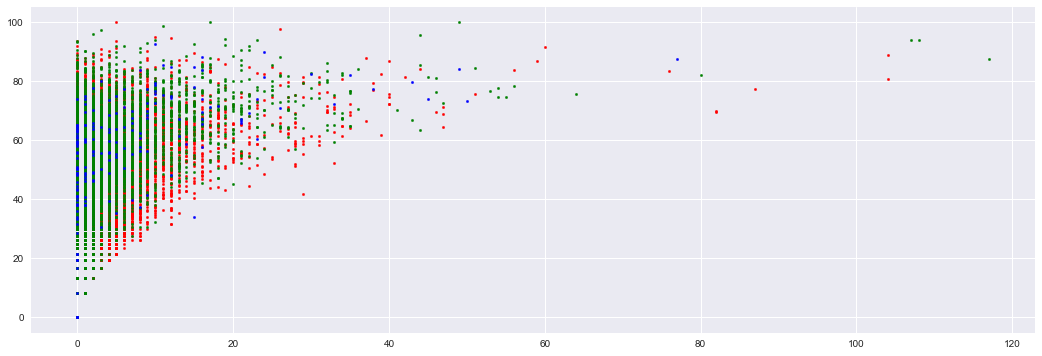

In [222]:
fig, axes = plt.subplots(figsize=(18,6))
axes.scatter(lowProducers["ncit_yr3_pub_yr3"], lowProducers["norm_ncit_yr15_pub_yr15_log"],  c="r", s=6)
axes.scatter(normalProducers["ncit_yr3_pub_yr3"], normalProducers["norm_ncit_yr15_pub_yr15_log"],  c="g", s=6)
axes.scatter(extraOrdinaryProducers["ncit_yr3_pub_yr3"], extraOrdinaryProducers["norm_ncit_yr15_pub_yr15_log"],  c="b", s=6)

plt.show()

                             ncit_yr3_pub_yr3  norm_ncit_yr15_pub_yr15_log
ncit_yr3_pub_yr3                     1.000000                     0.338784
norm_ncit_yr15_pub_yr15_log          0.338784                     1.000000
                             ncit_yr3_pub_yr3  norm_ncit_yr15_pub_yr15_log
ncit_yr3_pub_yr3                     1.000000                     0.410944
norm_ncit_yr15_pub_yr15_log          0.410944                     1.000000
                             ncit_yr3_pub_yr3  norm_ncit_yr15_pub_yr15_log
ncit_yr3_pub_yr3                     1.000000                     0.497885
norm_ncit_yr15_pub_yr15_log          0.497885                     1.000000


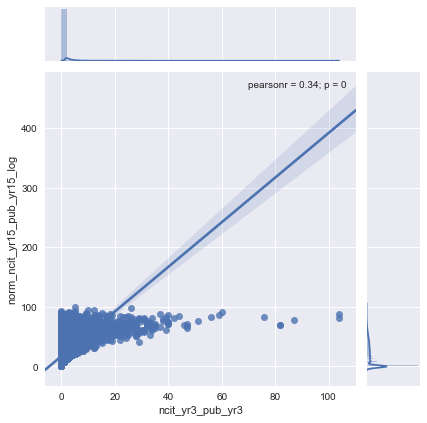

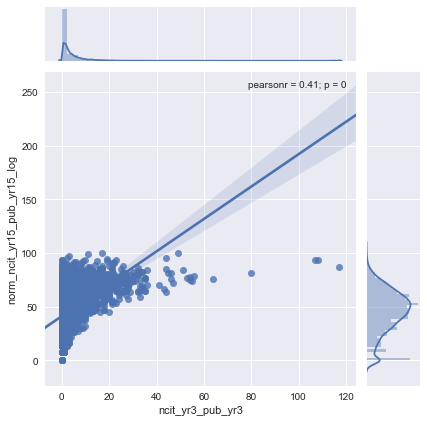

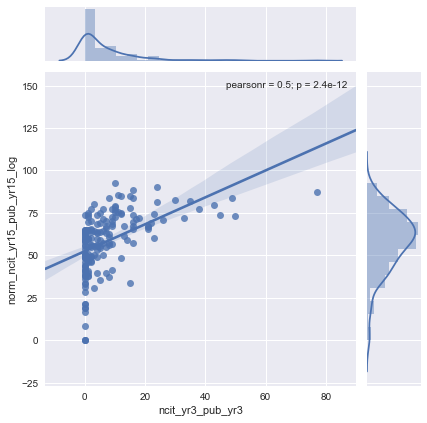

In [223]:
#plt.xcorr(lowProducers['ncit_yr3_pub_yr3'], lowProducers['norm_ncit_yr15_pub_yr15_log'])
lp_corr = lowProducers[['ncit_yr3_pub_yr3','norm_ncit_yr15_pub_yr15_log' ]].corr()
np_corr = normalProducers[['ncit_yr3_pub_yr3','norm_ncit_yr15_pub_yr15_log' ]].corr()
ep_corr = extraOrdinaryProducers[['ncit_yr3_pub_yr3','norm_ncit_yr15_pub_yr15_log' ]].corr()
print(lp_corr)
print(np_corr)
print(ep_corr)

#fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(18,6))
g = sns.jointplot("ncit_yr3_pub_yr3", "norm_ncit_yr15_pub_yr15_log", data=lowProducers, kind="reg")
g = sns.jointplot("ncit_yr3_pub_yr3", "norm_ncit_yr15_pub_yr15_log", data=normalProducers, kind="reg")
g = sns.jointplot("ncit_yr3_pub_yr3", "norm_ncit_yr15_pub_yr15_log", data=extraOrdinaryProducers, kind="reg")

#g.jointplot("ncit_yr3_pub_yr3", "norm_ncit_yr15_pub_yr15_log", data=normalProducers, kind="reg")

In [156]:
print(credibleAuthors[credibleAuthors['ncit_yr15_pub_yr15'] == 0].shape)
print(credibleAuthors[credibleAuthors['norm_ncit_yr15_pub_yr15'] == 0].shape)
print(credibleAuthors[credibleAuthors['ncit_yr15_pub_yr15_log'] <= 0].shape)
print(credibleAuthors[credibleAuthors['norm_ncit_yr15_pub_yr15_log'] <= 0].shape)

(45956, 26)
(45956, 26)
(45956, 26)
(45956, 26)


In [157]:
credibleAuthors['ncit_yr15_pub_yr15'].shape

(126157,)

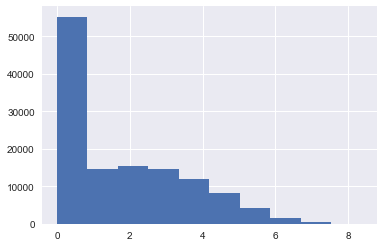

In [147]:
credibleAuthors['ncit_yr15_pub_yr15_log'].hist()

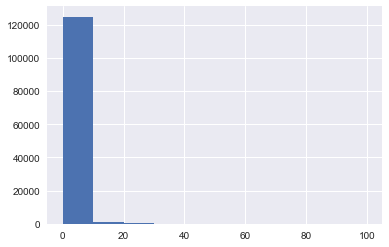

In [144]:
credibleAuthors['norm_ncit_yr15_pub_yr15'].hist()


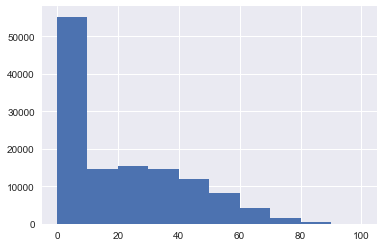

In [145]:
credibleAuthors['norm_ncit_yr15_pub_yr15_log'].hist()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


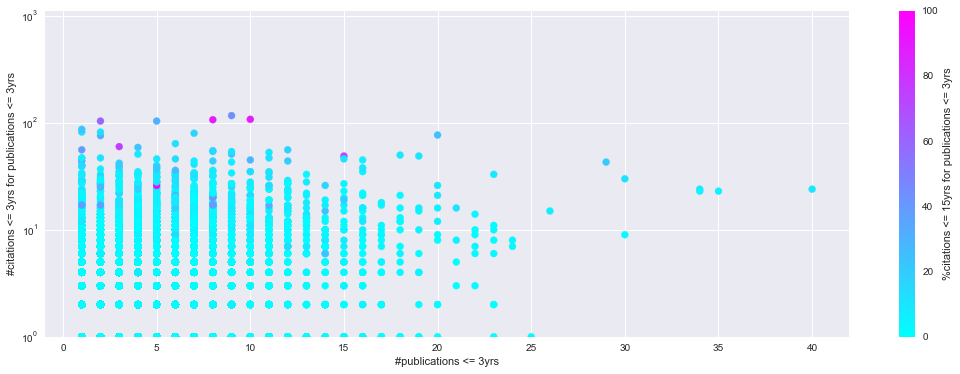

In [110]:
# Normalize(0 to 100) the citation obtained within 15 years for publication within 3 yrs
#credibleAuthors['norm_ncit_yr15_pub_yr3'] = 100 * ( (credibleAuthors['ncit_yr15_pub_yr3'] - credibleAuthors['ncit_yr15_pub_yr3'].min()) /
#                                            (credibleAuthors['ncit_yr15_pub_yr3'].max() - credibleAuthors['ncit_yr15_pub_yr3'].min()))
temp_max=credibleAuthors['ncit_yr15_pub_yr3'].max()
temp_min=credibleAuthors['ncit_yr15_pub_yr3'].min()
credibleAuthors['norm_ncit_yr15_pub_yr3'] = credibleAuthors.ncit_yr15_pub_yr3.apply(lambda x: 100 * ( float(x - temp_min)/float(temp_max - temp_min) ))

fig, axes = plt.subplots(figsize=(18,6))           

handle = axes.scatter(credibleAuthors['npub_yr3'], credibleAuthors['ncit_yr3_pub_yr3'], 
                   c=credibleAuthors['norm_ncit_yr15_pub_yr3'], cmap='cool')
axes.set_xlabel('#publications <= 3yrs')
axes.set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes.set_yscale('log')
axes.set_ylim(ymin=1)
cbar = fig.colorbar(handle)
cbar.set_label('%citations <= 15yrs for publications <= 3yrs')

plt.show()
#fig.savefig('fig/cit3_15yr-for-pub3yr.png')

8.3659050772
0.0


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


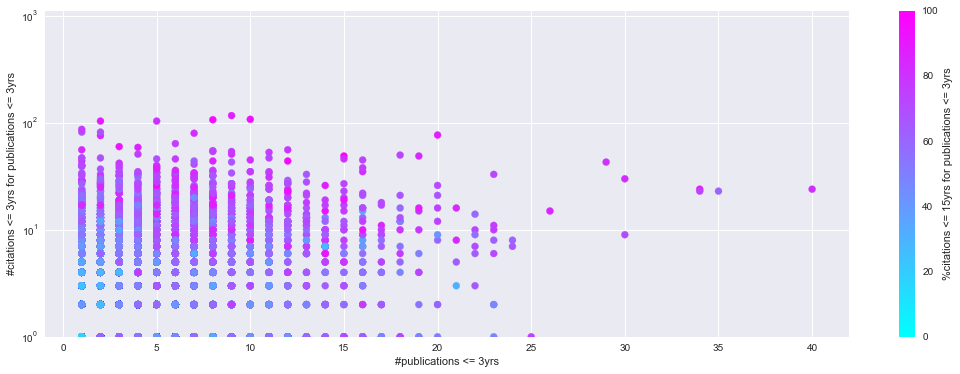

In [117]:
# Normalize(0 to 100) the citation obtained within 15 years for publication within 3 yrs
#credibleAuthors['norm_ncit_yr15_pub_yr3'] = 100 * ((credibleAuthors['ncit_yr15_pub_yr3'] - credibleAuthors['ncit_yr15_pub_yr3'].min()) /
#                                            (credibleAuthors['ncit_yr15_pub_yr3'].max() - credibleAuthors['ncit_yr15_pub_yr3'].min()))

temp_max=credibleAuthors['ncit_yr15_pub_yr15_log'].max()
temp_min=credibleAuthors['ncit_yr15_pub_yr15_log'].min()
credibleAuthors['norm_ncit_yr15_pub_yr15_log'] = credibleAuthors.ncit_yr15_pub_yr15_log.apply(lambda x: 100 * ( float(x - temp_min)
                                                                                                               /float(temp_max - temp_min) ))
print(temp_max)
print(temp_min)
#credibleAuthors['norm_ncit_yr15_pub_yr15_log']
fig, axes = plt.subplots(figsize=(18,6))

handle = axes.scatter(credibleAuthors['npub_yr3'], credibleAuthors['ncit_yr3_pub_yr3'], 
                   c=credibleAuthors['norm_ncit_yr15_pub_yr15_log'], cmap='cool')
axes.set_xlabel('#publications <= 3yrs')
axes.set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes.set_yscale('log')
axes.set_ylim(ymin=1)
cbar = fig.colorbar(handle)
cbar.set_label('%citations <= 15yrs for publications <= 3yrs')

plt.show()
# #fig.savefig('fig/cit3_15yr-for-pub3yr.png')

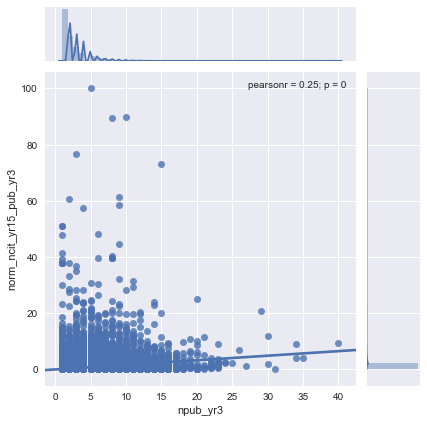

In [21]:
#fig, axes = plt.subplots(figsize=(18,6))

#handle = axes.scatter(credibleAuthors['npub_yr3'], credibleAuthors['norm_ncit_yr15_pub_yr3'])
#credibleAuthors[['npub_yr3',"norm_ncit_yr15_pub_yr3"]].corr()
#sns.regplot(x="npub_yr3", y="norm_ncit_yr15_pub_yr3", data=credibleAuthors,);
sns.jointplot(x="npub_yr3", y="norm_ncit_yr15_pub_yr3", data=credibleAuthors, kind="reg");

ValueError: cannot convert float NaN to integer

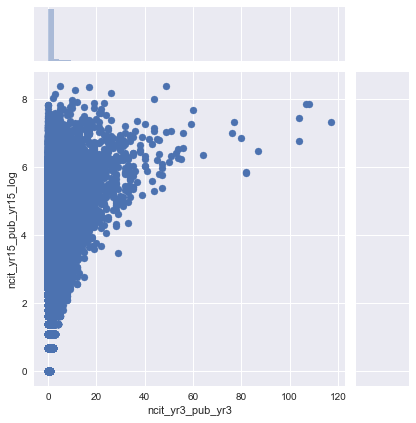

In [69]:
sns.jointplot(x="ncit_yr3_pub_yr3", y="ncit_yr15_pub_yr15_log", data=credibleAuthors, kind="reg");

In [76]:
np.log10(10)# 2.35

1.0

In [75]:
np.log(2.34) 

0.85015092936961001

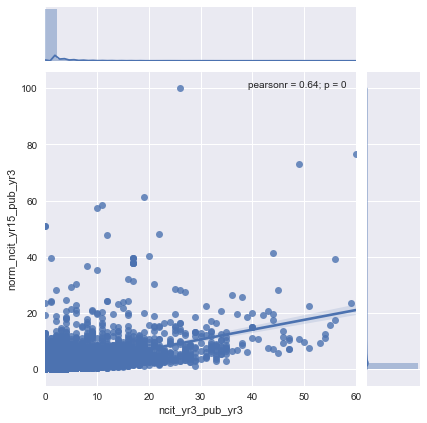

In [70]:
sns.jointplot(x="ncit_yr3_pub_yr3", y="norm_ncit_yr15_pub_yr3", data=credibleAuthors, kind="reg",xlim=(-0.1,60));

In [27]:
credibleAuthors[credibleAuthors.ncit_yr3_pub_yr3==0]#104816 is 0

,author,start_year,career_length,gender,npub_yr15,ncit_yr15_pub_yr15,ncit_yr15_top_3_pub,npub_yr3,ncit_yr15_pub_yr3,ncit_yr5_pub_yr3,...,ncit_yr15_pub_yr2,ncit_yr4_pub_yr2,ncit_yr3_pub_yr2,ncit_yr2_pub_yr2,npub_yr1,ncit_yr15_pub_yr1,ncit_yr3_pub_yr1,ncit_yr2_pub_yr1,ncit_yr1_pub_yr1,norm_ncit_yr15_pub_yr3
4,a min tjoa,1979,37,none,16,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0.000000
8,a-imam al-sammak,1992,17,m,5,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0.000000
18,a-xing zhu,1998,18,none,14,8,8,2,0,0,...,0,0,0,0,1,0,0,0,0,0.000000
24,a. a. (louis) beex,1980,37,none,11,0,0,2,0,0,...,0,0,0,0,2,0,0,0,0,0.000000
27,a. a. a. nasser,1993,22,none,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0.000000
48,a. a. abouelsoud,1996,21,none,4,0,0,3,0,0,...,0,0,0,0,2,0,0,0,0,0.000000
114,a. a. babaev,1988,27,none,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0.000000
175,a. a. diwan,1991,18,none,4,0,0,3,0,0,...,0,0,0,0,1,0,0,0,0,0.000000
197,a. a. elsadany,2002,15,none,9,5,5,2,5,0,...,5,0,0,0,1,5,0,0,0,0.180180
232,a. a. goldstein,1977,17,none,3,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0.000000


ERROR! Session/line number was not unique in database. History logging moved to new session 127


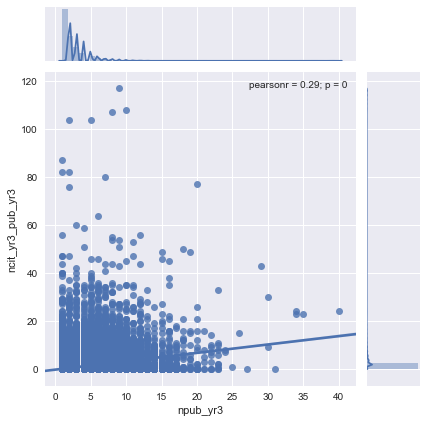

In [23]:
sns.jointplot(x="npub_yr3", y="ncit_yr3_pub_yr3", data=credibleAuthors, kind="reg");

In [251]:
# https://franciscomorales.org/2017/03/09/how-to-python-calculate-mahalanobis-distance/

import pandas as pd
from scipy.spatial.distance import mahalanobis
 
datadict = {
'country': ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Ecuador', 'Colombia', 'Paraguay', 'Peru', 'Venezuela'],
'd1': [0.34, -0.19, 0.37, 1.17, -0.31, -0.3, -0.48, -0.15, -0.61],
'd2': [-0.57, -0.69, -0.28, 0.68, -2.19, -0.83, -0.53, -1, -1.39],
'd3': [-0.02, -0.55, 0.07, 1.2, -0.14, -0.85, -0.9, -0.47, -1.02],
'd4': [-0.69, -0.18, 0.05, 1.43, -0.02, -0.7, -0.72, 0.23, -1.08],
'd5': [-0.83, -0.69, -0.39, 1.31, -0.7, -0.75, -1.04, -0.52, -1.22],
'd6': [-0.45, -0.77, 0.05, 1.37, -0.1, -0.67, -1.4, -0.35, -0.89]}
 
pairsdict = {
'country1': ['Argentina', 'Chile', 'Ecuador', 'Peru'],
'country2': ['Bolivia', 'Venezuela', 'Colombia', 'Peru']}
 
#DataFrame that contains the data for each country
df = pd.DataFrame(datadict)
 
#DataFrame that contains the pairs for which we calculate the Mahalanobis distance
pairs = pd.DataFrame(pairsdict)
 
#Add data to the country pairs
pairs = pairs.merge(df, how='left', left_on=['country1'], right_on=['country'])
pairs = pairs.merge(df, how='left', left_on=['country2'], right_on=['country'])
 
#Convert data columns to list in a single cell
pairs['vector1'] = pairs[['d1_x','d2_x','d3_x','d4_x','d5_x','d6_x']].values.tolist()
pairs['vector2'] = pairs[['d1_y','d2_y','d3_y','d4_y','d5_y','d6_y']].values.tolist()
 
mahala = pairs[['country1', 'country2', 'vector1', 'vector2']]
 
#Calculate covariance matrix
covmx = df.cov()
invcovmx = sp.linalg.inv(covmx)
 
#Calculate Mahalanobis distance
mahala['mahala_dist'] = mahala.apply(lambda x: (mahalanobis(x['vector1'], x['vector2'], invcovmx)), axis=1)
 
#mahala = mahala[['country1', 'country2', 'mahala_dist']]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [252]:
print(df.head())
print(pairs.head())

     country    d1    d2    d3    d4    d5    d6
0  Argentina  0.34 -0.57 -0.02 -0.69 -0.83 -0.45
1    Bolivia -0.19 -0.69 -0.55 -0.18 -0.69 -0.77
2     Brazil  0.37 -0.28  0.07  0.05 -0.39  0.05
3      Chile  1.17  0.68  1.20  1.43  1.31  1.37
4    Ecuador -0.31 -2.19 -0.14 -0.02 -0.70 -0.10
    country1   country2  country_x  d1_x  d2_x  d3_x  d4_x  d5_x  d6_x  \
0  Argentina    Bolivia  Argentina  0.34 -0.57 -0.02 -0.69 -0.83 -0.45   
1      Chile  Venezuela      Chile  1.17  0.68  1.20  1.43  1.31  1.37   
2    Ecuador   Colombia    Ecuador -0.31 -2.19 -0.14 -0.02 -0.70 -0.10   
3       Peru       Peru       Peru -0.15 -1.00 -0.47  0.23 -0.52 -0.35   

   country_y  d1_y  d2_y  d3_y  d4_y  d5_y  d6_y  \
0    Bolivia -0.19 -0.69 -0.55 -0.18 -0.69 -0.77   
1  Venezuela -0.61 -1.39 -1.02 -1.08 -1.22 -0.89   
2   Colombia -0.30 -0.83 -0.85 -0.70 -0.75 -0.67   
3       Peru -0.15 -1.00 -0.47  0.23 -0.52 -0.35   

                                     vector1  \
0  [0.34, -0.57, -0.02, -0

In [253]:
covmx

,d1,d2,d3,d4,d5,d6
d1,0.308219,0.336076,0.362882,0.330929,0.364354,0.382129
d2,0.336076,0.612753,0.317414,0.310521,0.402796,0.298033
d3,0.362882,0.317414,0.470394,0.446417,0.457854,0.504992
d4,0.330929,0.310521,0.446417,0.558800,0.516863,0.521400
d5,0.364354,0.402796,0.457854,0.516863,0.541750,0.531700
d6,0.382129,0.298033,0.504992,0.521400,0.531700,0.607925


In [254]:
invcovmx

array([[ 365.58608532, -127.84774778, -193.68413503,    4.2975029 ,
         130.68173124, -124.21521743],
       [-127.84774778,   53.30024479,   60.44383291,    6.38861357,
         -66.33737076,   56.56294558],
       [-193.68413503,   60.44383291,  129.85240758,   -9.12736729,
         -56.04327318,   41.09209861],
       [   4.2975029 ,    6.38861357,   -9.12736729,   23.0823724 ,
         -29.90387069,    8.10587243],
       [ 130.68173124,  -66.33737076,  -56.04327318,  -29.90387069,
         120.1321783 ,  -82.48972886],
       [-124.21521743,   56.56294558,   41.09209861,    8.10587243,
         -82.48972886,   83.05437989]])

In [255]:
mahalanobis(mahala['vector1'], mahala['vector2'], invcovmx)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [105]:
mahala.apply(lambda x: (mahalanobis(x['vector1'], x['vector2'], invcovmx)), axis=1)


0    3.003186
1    3.829020
2    3.915868
3    0.000000
dtype: float64

In [106]:
credibleAuthors.columns

Index([u'author', u'start_year', u'career_length', u'gender', u'npub_yr15',
       u'ncit_yr15_pub_yr15', u'ncit_yr15_top_3_pub', u'npub_yr3',
       u'ncit_yr15_pub_yr3', u'ncit_yr5_pub_yr3', u'ncit_yr4_pub_yr3',
       u'ncit_yr3_pub_yr3', u'npub_yr2', u'ncit_yr15_pub_yr2',
       u'ncit_yr4_pub_yr2', u'ncit_yr3_pub_yr2', u'ncit_yr2_pub_yr2',
       u'npub_yr1', u'ncit_yr15_pub_yr1', u'ncit_yr3_pub_yr1',
       u'ncit_yr2_pub_yr1', u'ncit_yr1_pub_yr1', u'norm_ncit_yr15_pub_yr3',
       u'norm_ncit_yr15_pub_yr15'],
      dtype='object')

In [149]:
tempCov = credibleAuthors[['npub_yr3', 'ncit_yr3_pub_yr3']].cov()
invCov = sp.linalg.inv(tempCov)
print(tempCov)
print(invCov)

                  npub_yr3  ncit_yr3_pub_yr3
npub_yr3          3.804438          1.328820
ncit_yr3_pub_yr3  1.328820          5.469437
[[ 0.28722462 -0.06978231]
 [-0.06978231  0.19978806]]


In [150]:
temp1 = credibleAuthors.apply(lambda row: (mahalanobis(credibleAuthors.iloc[20][['npub_yr3','ncit_yr3_pub_yr3']], 
                                                       row[['npub_yr3','ncit_yr3_pub_yr3']], invCov)), axis=1)
print(temp1)

0          0.446977
4          0.000000
8          0.000000
18         0.535933
24         0.535933
27         0.000000
48         1.071867
114        0.000000
121        1.034194
175        1.071867
197        0.535933
232        0.000000
269        0.000000
272        0.000000
288        0.000000
298        2.141052
399        0.000000
438        0.000000
441        0.000000
456        0.535933
587        0.000000
605        0.000000
623        0.000000
654        0.000000
668        0.000000
697        0.000000
701        0.535933
702        0.535933
716        1.071867
721        0.535933
             ...   
1707750    0.535933
1707772    0.000000
1707819    5.305025
1707834    1.071867
1707841    1.071867
1707842    1.071867
1707868    0.000000
1707873    0.589447
1707880    0.000000
1707882    0.535933
1707925    1.595865
1707948    0.535933
1707971    0.535933
1707983    0.535933
1707984    0.000000
1707993    1.607800
1708013    0.000000
1708022    0.000000
1708036    2.565954


In [165]:
#credibleAuthors.iloc[20][['npub_yr3','ncit_yr3_pub_yr3']].values.tolist()

from sklearn import metrics
temp2 = metrics.pairwise.pairwise_distances(credibleAuthors[['npub_yr3','ncit_yr3_pub_yr3']].as_matrix(), 
                                           credibleAuthors.iloc[20][['npub_yr3','ncit_yr3_pub_yr3']].values,
                                           metric='mahalanobis')
print(temp2)

[[ 0.44697834]
 [ 0.        ]
 [ 0.        ]
 ..., 
 [ 0.53593468]
 [ 1.07186937]
 [ 0.53593468]]


In [158]:
temp1Values = temp1.values
print(temp1Values)

[ 0.44697657  0.          0.         ...,  0.53593341  1.07186682
  0.53593341]


In [160]:
temp1Values = temp1.values
i = 0
equalValues = []
for temp2Value in temp2:
    equalValues.append(temp2Value[0] -  temp1Values[i])
#     if(temp2Value[0] == temp1Values[i]):
#         equalCount += 1
    i = i + 1
    #break
#temp1 == temp2
# print(equalCount)

108288


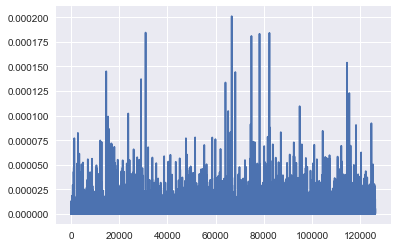

In [163]:
plt.plot(equalValues)
plt.show()

In [133]:
mahalanobis(credibleAuthors.iloc[20][['npub_yr3','ncit_yr3_pub_yr3']],
            credibleAuthors[['npub_yr3','ncit_yr3_pub_yr3']], 
            invCov)

ValueError: Input vector should be 1-D.

In [128]:
credibleAuthors.iloc[20][['npub_yr3','ncit_yr3_pub_yr3']].values.tolist()

[1, 0.0]

In [129]:
invcovmx

array([[ 365.58608532, -127.84774778, -193.68413503,    4.2975029 ,
         130.68173124, -124.21521743],
       [-127.84774778,   53.30024479,   60.44383291,    6.38861357,
         -66.33737076,   56.56294558],
       [-193.68413503,   60.44383291,  129.85240758,   -9.12736729,
         -56.04327318,   41.09209861],
       [   4.2975029 ,    6.38861357,   -9.12736729,   23.0823724 ,
         -29.90387069,    8.10587243],
       [ 130.68173124,  -66.33737076,  -56.04327318,  -29.90387069,
         120.1321783 ,  -82.48972886],
       [-124.21521743,   56.56294558,   41.09209861,    8.10587243,
         -82.48972886,   83.05437989]])

In [145]:
from io import StringIO
from sklearn import metrics

stringdata = StringIO(u"""pid,ratio1,pct1,rsp
    0,2.9,26.7,95.073615
    1,11.6,29.6,96.963660
    2,0.7,37.9,97.750412
    3,2.7,27.9,102.750412
    4,1.2,19.9,93.750412
    5,0.2,22.1,96.750412
    """)

stats = ['ratio1','pct1','rsp']
df = pd.read_csv(stringdata)

#dist = metrics.pairwise.pairwise_distances(df[stats].as_matrix(),
#    metric='mahalanobis')
dist = metrics.pairwise.pairwise_distances(df[stats].as_matrix(), [[1, 1,1],[1,1,1]], 
    metric='mahalanobis')
# dist = pd.DataFrame(dist)
# ranks = np.argsort(dist, axis=1)
# df["rankcol"] = ranks.apply(lambda row: ','.join(map(str, row)), axis=1)
# df
print(dist)

[[ 2.11117784  2.11117784]
 [ 3.1758122   3.1758122 ]
 [ 3.13561173  3.13561173]
 [ 2.2975248   2.2975248 ]
 [ 2.47736383  2.47736383]
 [ 2.47832254  2.47832254]]


In [148]:
dist

array([[ 0.44697834],
       [ 0.        ],
       [ 0.        ],
       ..., 
       [ 0.53593468],
       [ 1.07186937],
       [ 0.53593468]])

In [146]:
credibleAuthors.iloc[20][['npub_yr3','ncit_yr3_pub_yr3']].values

array([1, 0.0], dtype=object)

In [135]:
print(dist)

          0         1         2         3         4         5
0  0.000000  2.117839  1.965020  2.619605  1.096992  1.252910
1  2.117839  0.000000  3.143147  2.958985  2.751383  2.805914
2  1.965020  3.143147  0.000000  3.000390  2.917416  2.613683
3  2.619605  2.958985  3.000390  0.000000  2.922691  2.008519
4  1.096992  2.751383  2.917416  2.922691  0.000000  1.009184
5  1.252910  2.805914  2.613683  2.008519  1.009184  0.000000


In [137]:
print(ranks)

   0  1  2  3  4  5
0  0  4  5  2  1  3
1  1  0  4  5  3  2
2  2  0  5  4  3  1
3  3  5  0  4  1  2
4  4  5  0  1  2  3
5  5  4  0  3  2  1


In [136]:
df

,pid,ratio1,pct1,rsp,rankcol
0,0,2.9,26.7,95.073615,"0,4,5,2,1,3"
1,1,11.6,29.6,96.963660,"1,0,4,5,3,2"
2,2,0.7,37.9,97.750412,"2,0,5,4,3,1"
3,3,2.7,27.9,102.750412,"3,5,0,4,1,2"
4,4,1.2,19.9,93.750412,"4,5,0,1,2,3"
5,5,0.2,22.1,96.750412,"5,4,0,3,2,1"


In [142]:
from sklearn.metrics.pairwise import paired_distances
X = [[0, 1], [1, 1]]
Y = [[1, 1], [2, 1]]
paired_distances(X, Y, metric='mahalanobis')

ValueError: Unknown distance mahalanobis